import packages and libraries

In [1]:
import pandas as pd
import os
import pickle

take dataset and shuffle.

In [2]:
from sklearn.utils import shuffle

file_path = '../Sup/datset_fin.csv'
dataset = pd.read_csv(file_path,header=None)
dataset = shuffle(dataset)
dataset.head()

length = dataset.shape[0]
split_level = int(length*0.9)

inspect the dataset.

In [3]:
data = dataset[0]
data.head()

459     Sandler's interpretation of a female voice is ...
1367                None of their actions make any sense 
1793    unknown actors at the time of the film's origi...
1110                               his films are very bad
1395             The psychic is an unrealistic character 
Name: 0, dtype: object

In [4]:
label_cat = dataset[1]
label_cat.unique()

array(['CAST#PERFORMANCE', 'DIRECTING#PERFORMANCE'], dtype=object)

start nlp pipeline

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

preprocess the dataset the optimize the outputs.

In [6]:
data = data.str.lower()
aspect_terms = []
for review in nlp.pipe(data):
    chunks = [chunk.root.text for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
dataset[3] = aspect_terms

In [7]:
dataset.head()

,0,1,2,3
459,Sandler's interpretation of a female voice is ...,CAST#PERFORMANCE,Negative,interpretation voice
1367,None of their actions make any sense,CAST#PERFORMANCE,Negative,none actions sense
1793,unknown actors at the time of the film's origi...,CAST#PERFORMANCE,Positive,actors time release jack
1110,his films are very bad,DIRECTING#PERFORMANCE,Negative,films
1395,The psychic is an unrealistic character,CAST#PERFORMANCE,Negative,character


define the model

In [8]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(512, input_shape=(6000,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Using TensorFlow backend.


label encode the dataset to feed numerical values

In [9]:
from keras.preprocessing.text import Tokenizer

vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data)
aspect_tokeniz = pd.DataFrame(tokenizer.texts_to_matrix(dataset[3]))

split the dataset between train and validation datasets.

In [10]:
#from sklearn.preprocessing import LabelEncoder
#import numpy as np
#from keras.utils import to_categorical

#label_encoder = LabelEncoder()
#integer_category = label_encoder.fit_transform(label_cat)

label_cate = label_cat.apply(lambda x:0 if x=="DIRECTING#PERFORMANCE" else 0).values
aspect_tokenized = aspect_tokeniz.loc[:split_level-1,:]
test_X = aspect_tokeniz.loc[split_level:,:]

dummy_category = label_cate[:split_level]
test_y = label_cate[split_level:]

In [11]:
#history = model.fit(aspect_tokenized, dummy_category, epochs=20, verbose=1)

define visualization function.

In [11]:
import matplotlib.pylab as plt

def plot_var(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc , label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

train the model.

0 1800
37 1793
Train on 1800 samples, validate on 1756 samples
Epoch 1/5
1800/1800 [==============================] - 2s 1ms/step - loss: 0.3506 - accuracy: 0.9833 - val_loss: 0.0719 - val_accuracy: 1.0000

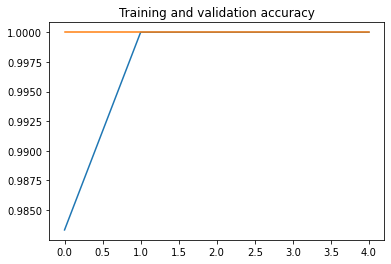

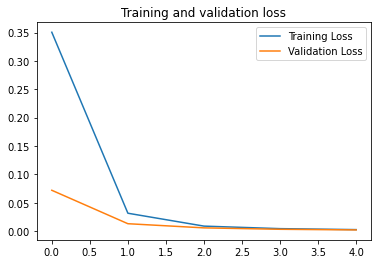

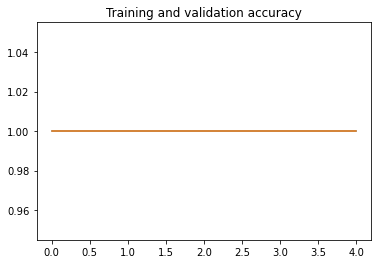

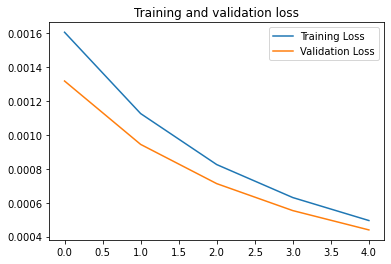

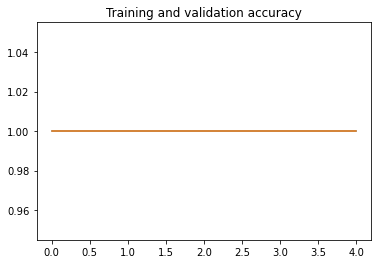

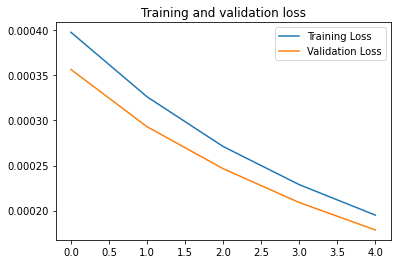

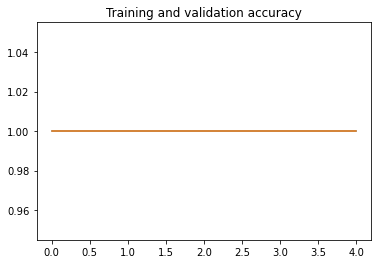

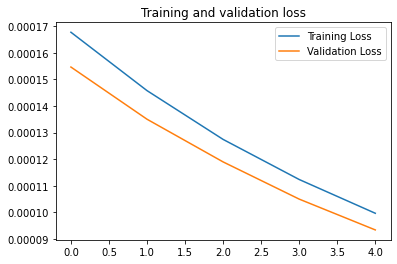

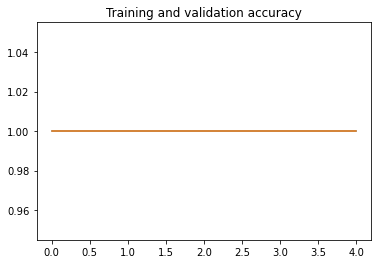

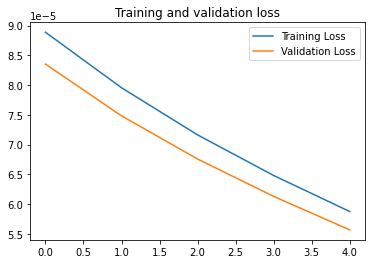

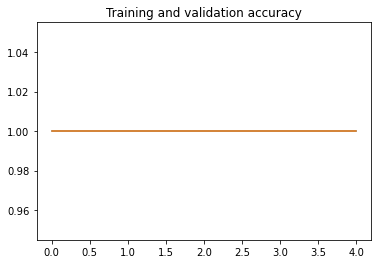

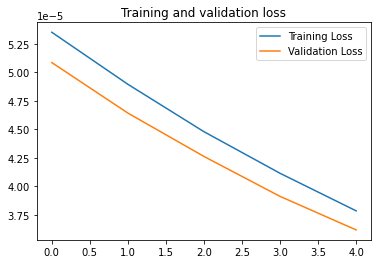

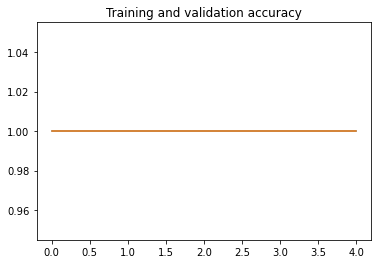

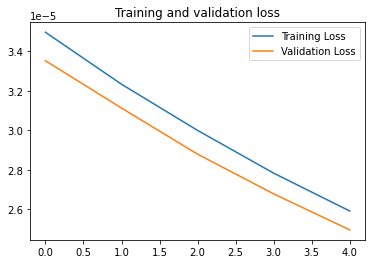

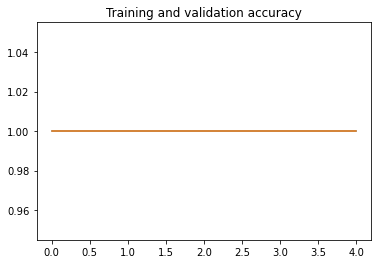

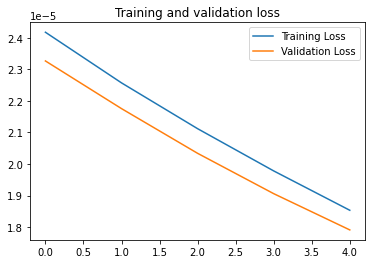

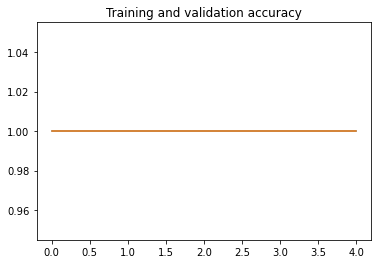

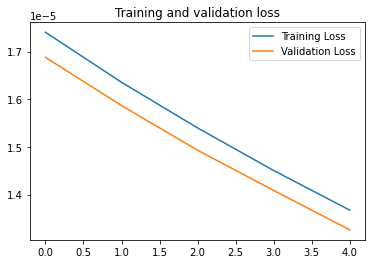

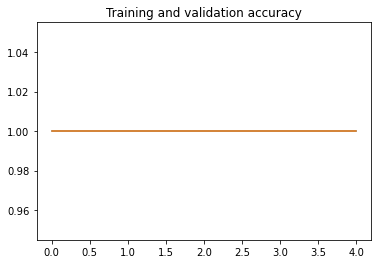

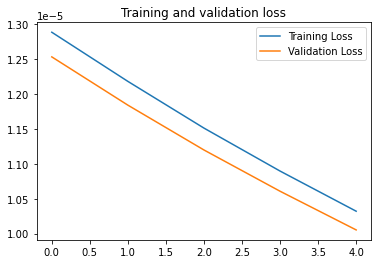

In [12]:
from sklearn.model_selection import KFold

cv = KFold(10,shuffle=True,random_state=1)
for train_ind,test_ind in cv.split(aspect_tokenized):
    print(train_ind[0],train_ind[-1])
    print(test_ind[0],test_ind[-1])
    train_start,train_end,test_start,test_end = train_ind[0],train_ind[-1],test_ind[0],test_ind[-1]
    X_train, X_test, y_train, y_test = aspect_tokenized.loc[train_start:train_end-1,:],\
                                       aspect_tokenized.loc[test_start:test_end-1,:], \
                                       dummy_category[train_start:train_end], \
                                       dummy_category[test_start:test_end]
    history = model.fit(X_train,y_train,epochs=5,verbose=1,validation_data=(X_test,y_test))
    plot_var(history)

model saving

In [13]:
model_save_path = '../Sup'
weight_save_path = '../Sup'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
if not os.path.exists(weight_save_path):
    os.mkdir(weight_save_path)
model.save( '../Sup/categorical_model_fin.h5')
model.save_weights( "../Sup/categorical_model_fin_weights.h5")

In [14]:
# saving
#if not os.path.exists('../Sup/tokenizer.pickle'):
#    os.mkdir('../Sup/tokenizer.pickle')
with open('../Sup/categorical_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


evaluate the model on the test set

In [15]:
logs = model.evaluate(test_X,test_y)
print(logs)

201/201 [==============================] - 0s 139us/step
[1.5110377119784591e-05, 1.0]
